In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Global variables to store data and models between cells
df_enhanced = None
kpis = {}
model_results = {}
best_model = None
best_model_name = ""
scaler = None
feature_columns = []
encoders = {}

In [ ]:
def load_and_prepare_data(data_path='cleaned_customs_data.csv'):
    """Load and prepare the dataset - Run this first!"""
    global df_enhanced

    print("🔄 Loading and preparing dataset...")

    try:
        df = pd.read_csv(data_path, parse_dates=['Receipt_Date'])
        print(f"✅ Data loaded successfully: {df.shape[0]} rows, {df.shape[1]} columns")
    except FileNotFoundError:
        print(f"❌ Error: '{data_path}' not found.")
        print("Please ensure the dataset is in the current directory.")
        return None

    # Remove rows with missing critical values
    df = df.dropna(subset=['Tax_per_KG'])

    print(f"📊 Dataset info after cleaning:")
    print(f"   Rows: {df.shape[0]:,}")
    print(f"   Columns: {df.shape[1]}")
    print(f"   Date range: {df['Receipt_Date'].min()} to {df['Receipt_Date'].max()}")
    print(f"   Total CIF Value: {df['CIF_Value_N'].sum()/1e12:.2f} Trillion N")

    df_enhanced = df
    return df
df = load_and_prepare_data('cleaned_customs_data.csv')

🔄 Loading and preparing dataset...
✅ Data loaded successfully: 76352 rows, 26 columns
📊 Dataset info after cleaning:
   Rows: 74,642
   Columns: 26
   Date range: 2023-01-02 00:00:00 to 2026-10-18 00:00:00
   Total CIF Value: 1.70 Trillion N


In [ ]:
pd.set_option('display.max_columns', None)
df

,ID,Custom_Office,Reg_Number,Importer,HS_Code,FOB_Value_N,CIF_Value_N,Total_Tax_N,Receipt_Number,Receipt_Date,Mass_KG,Country_of_Origin,Country_of_Supply,Nbr_Of_Containers,Container_Nbr,Container_Size,Is_High_Value,Tax_to_Value_Ratio,Is_Suspicious_Tax,FOB_CIF_Diff,Tax_per_KG,HS_Code_Category,Tax_to_FOB_Ratio,Has_Containers,Shipment_Type,Mass_Category
0,0,UA PORT,C1195,29143,129000,1046575,1119220,137105,R599,2023-07-03,126,Germany,Germany,0,NaN,NaN,0,0.122500,0,72645,1088.134921,12,0.131004,0,Non-Containerized,Medium
1,1,UA PORT,C1195,29143,367000,216957,232002,68365,R599,2023-07-03,26,Germany,Germany,0,NaN,NaN,0,0.294674,0,15045,2629.423077,36,0.315109,0,Non-Containerized,Low
2,2,UA PORT,C1195,29143,393900,172037,183858,54415,R599,2023-07-03,21,Germany,Germany,0,NaN,NaN,0,0.295962,0,11821,2591.190476,39,0.316298,0,Non-Containerized,Low
3,3,UA PORT,C1277,62056,408900,776007,915286,162868,R621,2023-08-03,71,Belgium,Belgium,0,NaN,NaN,0,0.177942,0,139279,2293.915493,40,0.209880,0,Non-Containerized,Low
4,4,UA PORT,C1292,93763,371000,234651,301040,37415,R614,2023-08-03,45,Turkey,Turkey,0,NaN,NaN,0,0.124286,0,66389,831.444444,37,0.159450,0,Non-Containerized,Low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76347,77767,NT_2,C253,94193,353000,1253338,1509044,182954,R241,2023-03-23,2000,China,China,1,CAIU3628076,20DV,0,0.121238,0,255706,91.477000,35,0.145973,1,Containerized,High
76348,77779,RW PORT,C559,7372,164000,4249945,4621740,67183,R336,2023-12-21,4483,Germany,Germany,0,NaN,NaN,0,0.014536,0,371795,14.986170,16,0.015808,0,Non-Containerized,High
76349,77781,RW PORT,C571,71449,300000,926896600,1055887200,14549978,R177,2024-03-02,141000,United Kingdom,United Kingdom,0,NaN,NaN,1,0.013780,1,128990600,103.191333,30,0.015698,0,Non-Containerized,High
76350,77782,RW PORT,C167,37573,318000,21206286,23519854,4165911,R166,2023-01-19,38,Italy,Italy,0,NaN,NaN,0,0.177123,0,2313568,109629.236800,31,0.196447,0,Non-Containerized,Low


In [ ]:
def enhanced_feature_engineering():
    """Enhanced feature engineering - Run after loading data"""
    global df_enhanced, encoders

    if df_enhanced is None:
        print("❌ Error: Please run load_and_prepare_data() first!")
        return None

    print("🔧 Creating enhanced features...")

    # 1. Time-based features
    df_enhanced['Receipt_Year'] = df_enhanced['Receipt_Date'].dt.year
    df_enhanced['Receipt_Month'] = df_enhanced['Receipt_Date'].dt.month
    df_enhanced['Receipt_Quarter'] = df_enhanced['Receipt_Date'].dt.quarter
    df_enhanced['Days_Since_Start'] = (df_enhanced['Receipt_Date'] - df_enhanced['Receipt_Date'].min()).dt.days

    # 2. Value-based ratios and metrics
    df_enhanced['CIF_FOB_Ratio'] = df_enhanced['CIF_Value_N'] / (df_enhanced['FOB_Value_N'] + 1)
    df_enhanced['Tax_Efficiency'] = df_enhanced['Total_Tax_N'] / (df_enhanced['CIF_Value_N'] + 1)
    df_enhanced['Value_per_KG'] = df_enhanced['CIF_Value_N'] / (df_enhanced['Mass_KG'] + 1)

    # 3. Categorical encoding for important features
    le_country = LabelEncoder()
    le_office = LabelEncoder()
    le_hs = LabelEncoder()

    df_enhanced['Country_Encoded'] = le_country.fit_transform(df_enhanced['Country_of_Origin'])
    df_enhanced['Office_Encoded'] = le_office.fit_transform(df_enhanced['Custom_Office'])
    df_enhanced['HS_Category_Encoded'] = le_hs.fit_transform(df_enhanced['HS_Code_Category'])

    # Store encoders globally
    encoders = {
        'country': le_country,
        'office': le_office,
        'hs_category': le_hs
    }

    # 4. Risk and compliance features
    df_enhanced['High_Value_Threshold'] = (df_enhanced['CIF_Value_N'] > df_enhanced['CIF_Value_N'].quantile(0.95)).astype(int)
    df_enhanced['Tax_Anomaly'] = ((df_enhanced['Tax_to_Value_Ratio'] < df_enhanced['Tax_to_Value_Ratio'].quantile(0.05)) |
                                 (df_enhanced['Tax_to_Value_Ratio'] > df_enhanced['Tax_to_Value_Ratio'].quantile(0.95))).astype(int)

    print(f"✅ Feature engineering completed!")
    print(f"   New features created: {len([col for col in df_enhanced.columns if col.endswith(('_Encoded', '_Threshold', '_Anomaly', '_Efficiency', '_Ratio', 'Value_per_KG'))])} additional features")
    print(f"   Total columns now: {df_enhanced.shape[1]}")

    return df_enhanced

df_enhanced = enhanced_feature_engineering()


🔧 Creating enhanced features...
✅ Feature engineering completed!
   New features created: 10 additional features
   Total columns now: 38


In [ ]:
# Set options to display all columns and more rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

df

,ID,Custom_Office,Reg_Number,Importer,HS_Code,FOB_Value_N,CIF_Value_N,Total_Tax_N,Receipt_Number,Receipt_Date,Mass_KG,Country_of_Origin,Country_of_Supply,Nbr_Of_Containers,Container_Nbr,Container_Size,Is_High_Value,Tax_to_Value_Ratio,Is_Suspicious_Tax,FOB_CIF_Diff,Tax_per_KG,HS_Code_Category,Tax_to_FOB_Ratio,Has_Containers,Shipment_Type,Mass_Category,Receipt_Year,Receipt_Month,Receipt_Quarter,Days_Since_Start,CIF_FOB_Ratio,Tax_Efficiency,Value_per_KG,Country_Encoded,Office_Encoded,HS_Category_Encoded,High_Value_Threshold,Tax_Anomaly
0,0,UA PORT,C1195,29143,129000,1046575,1119220,137105,R599,2023-07-03,126,Germany,Germany,0,NaN,NaN,0,0.122500,0,72645,1088.134921,12,0.131004,0,Non-Containerized,Medium,2023,7,3,182,1.069411,0.122500,8812.755906,45,14,2,0,0
1,1,UA PORT,C1195,29143,367000,216957,232002,68365,R599,2023-07-03,26,Germany,Germany,0,NaN,NaN,0,0.294674,0,15045,2629.423077,36,0.315109,0,Non-Containerized,Low,2023,7,3,182,1.069341,0.294673,8592.666667,45,14,25,0,0
2,2,UA PORT,C1195,29143,393900,172037,183858,54415,R599,2023-07-03,21,Germany,Germany,0,NaN,NaN,0,0.295962,0,11821,2591.190476,39,0.316298,0,Non-Containerized,Low,2023,7,3,182,1.068706,0.295960,8357.181818,45,14,28,0,0
3,3,UA PORT,C1277,62056,408900,776007,915286,162868,R621,2023-08-03,71,Belgium,Belgium,0,NaN,NaN,0,0.177942,0,139279,2293.915493,40,0.209880,0,Non-Containerized,Low,2023,8,3,213,1.179480,0.177942,12712.305556,12,14,29,0,0
4,4,UA PORT,C1292,93763,371000,234651,301040,37415,R614,2023-08-03,45,Turkey,Turkey,0,NaN,NaN,0,0.124286,0,66389,831.444444,37,0.159450,0,Non-Containerized,Low,2023,8,3,213,1.282921,0.124285,6544.347826,121,14,26,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76347,77767,NT_2,C253,94193,353000,1253338,1509044,182954,R241,2023-03-23,2000,China,China,1,CAIU3628076,20DV,0,0.121238,0,255706,91.477000,35,0.145973,1,Containerized,High,2023,3,1,80,1.204019,0.121238,754.144928,24,8,24,0,0
76348,77779,RW PORT,C559,7372,164000,4249945,4621740,67183,R336,2023-12-21,4483,Germany,Germany,0,NaN,NaN,0,0.014536,0,371795,14.986170,16,0.015808,0,Non-Containerized,High,2023,12,4,353,1.087482,0.014536,1030.718109,45,13,6,0,1
76349,77781,RW PORT,C571,71449,300000,926896600,1055887200,14549978,R177,2024-03-02,141000,United Kingdom,United Kingdom,0,NaN,NaN,1,0.013780,1,128990600,103.191333,30,0.015698,0,Non-Containerized,High,2024,3,1,425,1.139164,0.013780,7488.508592,125,13,19,1,1
76350,77782,RW PORT,C167,37573,318000,21206286,23519854,4165911,R166,2023-01-19,38,Italy,Italy,0,NaN,NaN,0,0.177123,0,2313568,109629.236800,31,0.196447,0,Non-Containerized,Low,2023,1,1,17,1.109098,0.177123,603073.179487,61,13,20,0,0


In [ ]:
def calculate_comprehensive_kpis():
    """Calculate comprehensive KPIs - Run after feature engineering"""
    global df_enhanced, kpis

    if df_enhanced is None:
        print("❌ Error: Please run feature engineering first!")
        return None

    print("📊 Calculating comprehensive KPIs...")

    # 1. Import Volume and Value KPIs
    kpis['import_volume_value'] = {
        'total_fob': df_enhanced['FOB_Value_N'].sum(),
        'total_cif': df_enhanced['CIF_Value_N'].sum(),
        'avg_fob_per_transaction': df_enhanced['FOB_Value_N'].mean(),
        'avg_cif_per_transaction': df_enhanced['CIF_Value_N'].mean(),
        'top_7_countries_by_value': df_enhanced.groupby('Country_of_Origin')['CIF_Value_N'].sum().nlargest(7),
        'top_7_importers_by_volume': df_enhanced.groupby('Importer')['Mass_KG'].sum().nlargest(7),
        'avg_mass_per_transaction': df_enhanced['Mass_KG'].mean()
    }

    # 2. Taxation and Revenue KPIs
    kpis['taxation_revenue'] = {
        'total_tax_collected': df_enhanced['Total_Tax_N'].sum(),
        'avg_tax_per_transaction': df_enhanced['Total_Tax_N'].mean(),
        'avg_tax_to_value_ratio': df_enhanced['Tax_to_Value_Ratio'].mean(),
        'top_5_tax_contributing_importers': df_enhanced.groupby('Importer')['Total_Tax_N'].sum().nlargest(5)
    }

    # 3. Logistics and Shipment KPIs
    containerized_df = df_enhanced[df_enhanced['Container_Size'] != 'None']
    kpis['logistics_shipment'] = {
        'total_shipments': len(df_enhanced),
        'avg_containers_per_importer': df_enhanced.groupby('Importer')['Nbr_Of_Containers'].mean().mean(),
        'most_common_container_size': containerized_df['Container_Size'].mode()[0] if len(containerized_df) > 0 else 'None',
        'total_weight_by_country': df_enhanced.groupby('Country_of_Origin')['Mass_KG'].sum().nlargest(7)
    }

    # 4. Compliance and Processing KPIs
    kpis['compliance_processing'] = {
        'transactions_per_office': df_enhanced.groupby('Custom_Office')['ID'].count().sort_values(ascending=False),
        'top_5_hs_codes_by_frequency': df_enhanced.groupby('HS_Code_Category')['ID'].count().nlargest(5),
        'top_5_hs_codes_by_value': df_enhanced.groupby('HS_Code_Category')['CIF_Value_N'].sum().nlargest(5),
        'pct_high_value_imports': (df_enhanced['Is_High_Value'].sum() / len(df_enhanced)) * 100,
        'pct_suspicious_tax': (df_enhanced['Is_Suspicious_Tax'].sum() / len(df_enhanced)) * 100
    }

    # Display key KPIs
    print("✅ KPI CALCULATION COMPLETED!")
    print("\n📊 KEY PERFORMANCE INDICATORS:")
    print("-" * 50)
    print(f"💰 Total CIF Value: {kpis['import_volume_value']['total_cif']/1e12:.2f} Trillion N")
    print(f"💰 Total FOB Value: {kpis['import_volume_value']['total_fob']/1e12:.2f} Trillion N")
    print(f"💰 Total Tax Collected: {kpis['taxation_revenue']['total_tax_collected']/1e9:.1f} Billion N")
    print(f"📦 Total Transactions: {kpis['logistics_shipment']['total_shipments']:,}")
    print(f"📈 Average Tax Ratio: {kpis['taxation_revenue']['avg_tax_to_value_ratio']:.3f}")
    print(f"🚨 High Value Imports: {kpis['compliance_processing']['pct_high_value_imports']:.2f}%")
    print(f"🚨 Suspicious Transactions: {kpis['compliance_processing']['pct_suspicious_tax']:.2f}%")
    print(f"🌍 Top Import Country: {kpis['import_volume_value']['top_7_countries_by_value'].index[0]}")

    return kpis

kpis = calculate_comprehensive_kpis()


📊 Calculating comprehensive KPIs...
✅ KPI CALCULATION COMPLETED!

📊 KEY PERFORMANCE INDICATORS:
--------------------------------------------------
💰 Total CIF Value: 1.70 Trillion N
💰 Total FOB Value: 1.58 Trillion N
💰 Total Tax Collected: 242.1 Billion N
📦 Total Transactions: 74,642
📈 Average Tax Ratio: 0.192
🚨 High Value Imports: 0.91%
🚨 Suspicious Transactions: 1.05%
🌍 Top Import Country: China


📈 Creating country analysis visualizations...


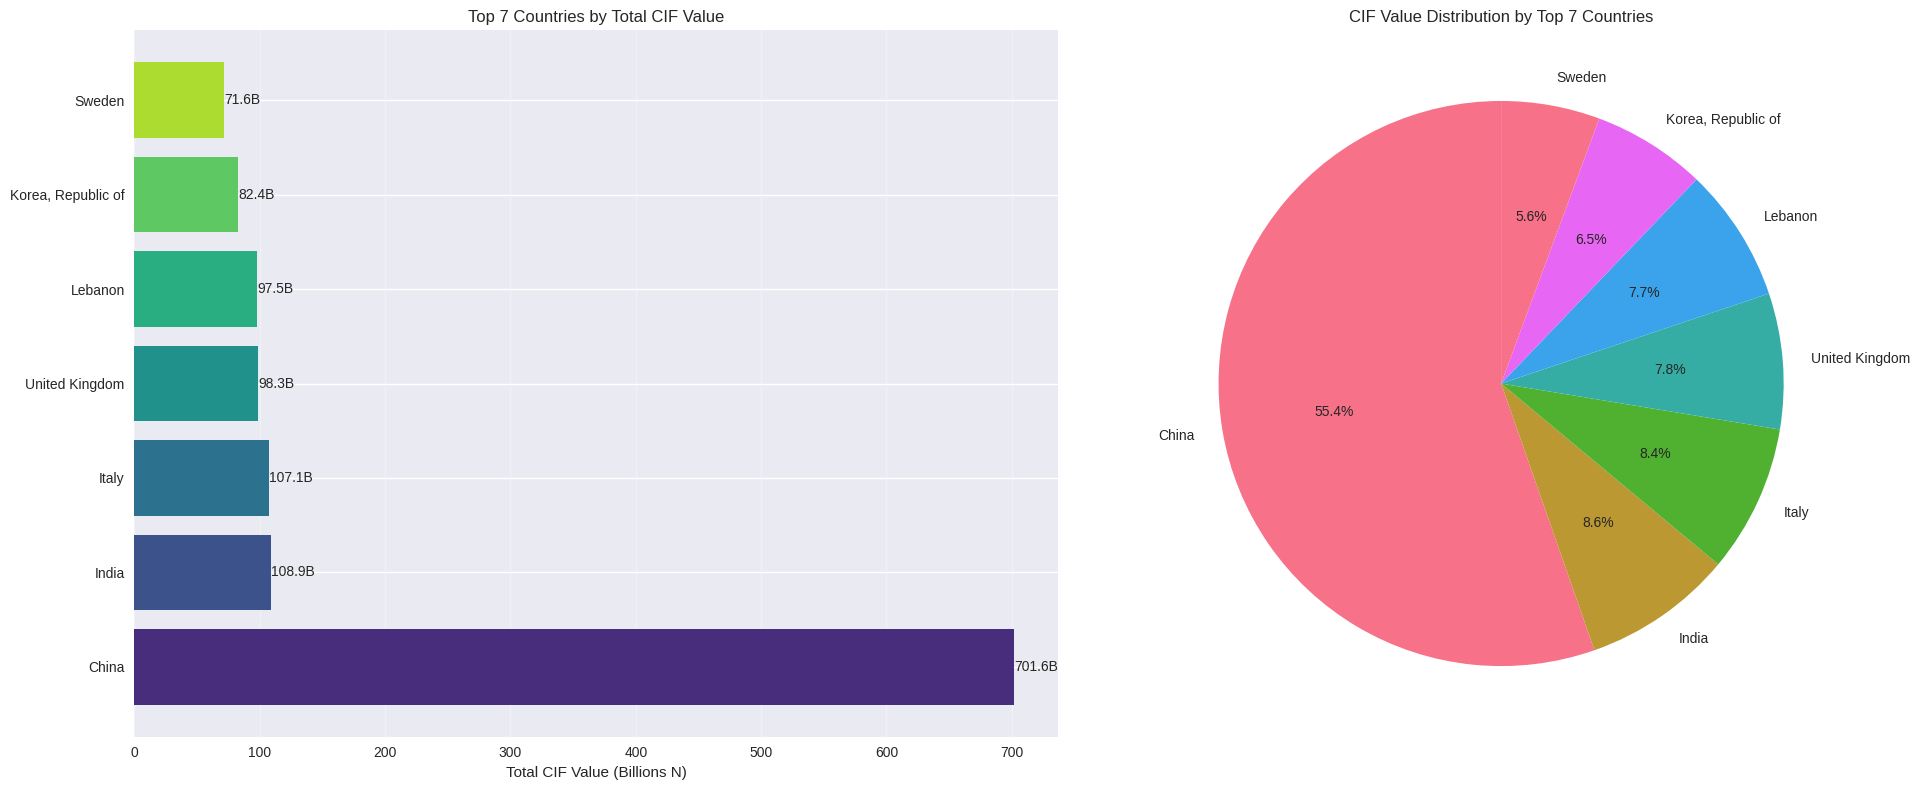

✅ Country analysis visualization created and saved!


In [ ]:
def create_country_analysis_visualization():
    """Create enhanced country analysis visualizations"""
    global df_enhanced, kpis

    if not kpis or df_enhanced is None:
        print("❌ Error: Please calculate KPIs first!")
        return

    print("📈 Creating country analysis visualizations...")

    # Set up the plotting style
    plt.rcParams['figure.figsize'] = (12, 8)
    plt.rcParams['font.size'] = 10

    # Top Countries by CIF Value (Enhanced)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    top_countries = kpis['import_volume_value']['top_7_countries_by_value']
    bars1 = ax1.barh(range(len(top_countries)), top_countries.values / 1e9,
                    color=sns.color_palette("viridis", len(top_countries)))
    ax1.set_yticks(range(len(top_countries)))
    ax1.set_yticklabels(top_countries.index)
    ax1.set_xlabel('Total CIF Value (Billions N)')
    ax1.set_title('Top 7 Countries by Total CIF Value')
    ax1.grid(axis='x', alpha=0.3)

    # Add value labels on bars
    for i, (bar, value) in enumerate(zip(bars1, top_countries.values)):
        ax1.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
                f'{value/1e9:.1f}B', va='center')

    # Pie chart for proportion
    ax2.pie(top_countries.values, labels=top_countries.index, autopct='%1.1f%%',
           startangle=90)
    ax2.set_title('CIF Value Distribution by Top 7 Countries')

    plt.tight_layout()
    plt.savefig('enhanced_top_countries_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("✅ Country analysis visualization created and saved!")

create_country_analysis_visualization()

📊 Creating tax analysis dashboard...


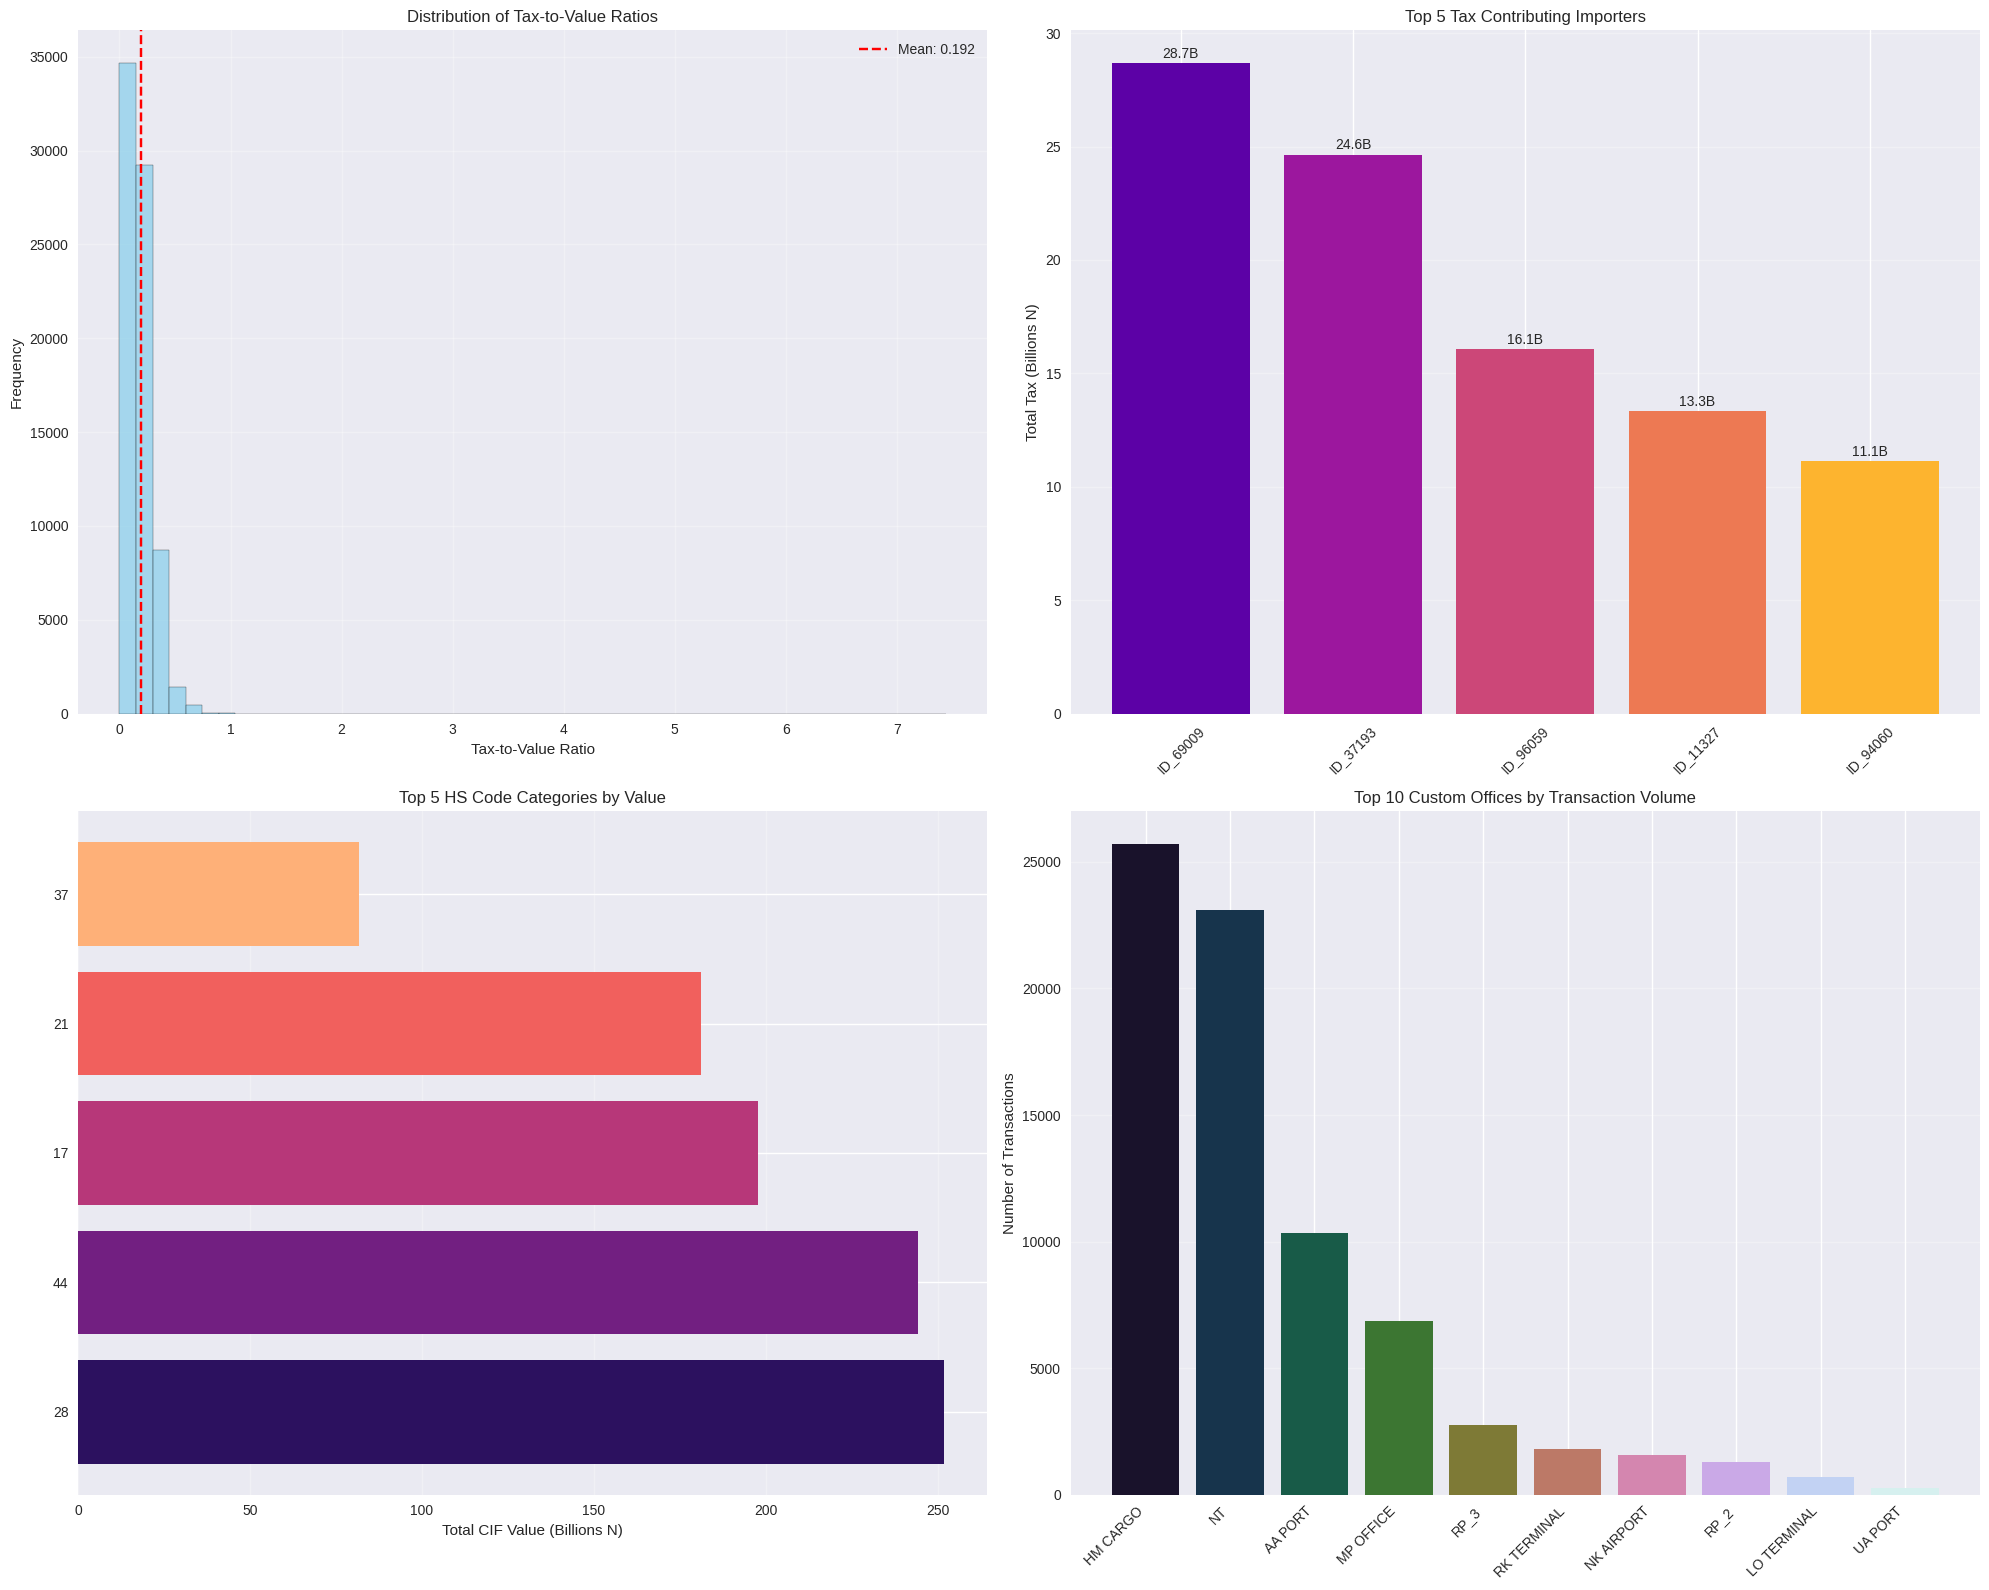

✅ Tax analysis dashboard created and saved!


In [ ]:
def create_tax_analysis_dashboard():
    """Create comprehensive tax analysis dashboard"""
    global df_enhanced, kpis

    if not kpis or df_enhanced is None:
        print("❌ Error: Please calculate KPIs first!")
        return

    print("📊 Creating tax analysis dashboard...")

    # Tax Analysis Dashboard
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))

    # Tax distribution
    ax1.hist(df_enhanced['Tax_to_Value_Ratio'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    ax1.axvline(df_enhanced['Tax_to_Value_Ratio'].mean(), color='red', linestyle='--',
               label=f'Mean: {df_enhanced["Tax_to_Value_Ratio"].mean():.3f}')
    ax1.set_xlabel('Tax-to-Value Ratio')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Distribution of Tax-to-Value Ratios')
    ax1.legend()
    ax1.grid(alpha=0.3)

    # Top importers by tax
    top_importers = kpis['taxation_revenue']['top_5_tax_contributing_importers']
    bars2 = ax2.bar(range(len(top_importers)), top_importers.values / 1e9,
                   color=sns.color_palette("plasma", len(top_importers)))
    ax2.set_xticks(range(len(top_importers)))
    ax2.set_xticklabels([f'ID_{idx}' for idx in top_importers.index], rotation=45)
    ax2.set_ylabel('Total Tax (Billions N)')
    ax2.set_title('Top 5 Tax Contributing Importers')
    ax2.grid(axis='y', alpha=0.3)

    # Add value labels
    for bar, value in zip(bars2, top_importers.values):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                f'{value/1e9:.1f}B', ha='center', va='bottom')

    # HS Code analysis
    top_hs = kpis['compliance_processing']['top_5_hs_codes_by_value']
    ax3.barh(range(len(top_hs)), top_hs.values / 1e9,
            color=sns.color_palette("magma", len(top_hs)))
    ax3.set_yticks(range(len(top_hs)))
    ax3.set_yticklabels(top_hs.index)
    ax3.set_xlabel('Total CIF Value (Billions N)')
    ax3.set_title('Top 5 HS Code Categories by Value')
    ax3.grid(axis='x', alpha=0.3)

    # Transactions per office
    transactions = kpis['compliance_processing']['transactions_per_office'].head(10)
    ax4.bar(range(len(transactions)), transactions.values,
           color=sns.color_palette("cubehelix", len(transactions)))
    ax4.set_xticks(range(len(transactions)))
    ax4.set_xticklabels(transactions.index, rotation=45, ha='right')
    ax4.set_ylabel('Number of Transactions')
    ax4.set_title('Top 10 Custom Offices by Transaction Volume')
    ax4.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.savefig('tax_analysis_dashboard.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("✅ Tax analysis dashboard created and saved!")

create_tax_analysis_dashboard()

📅 Creating seasonal analysis...


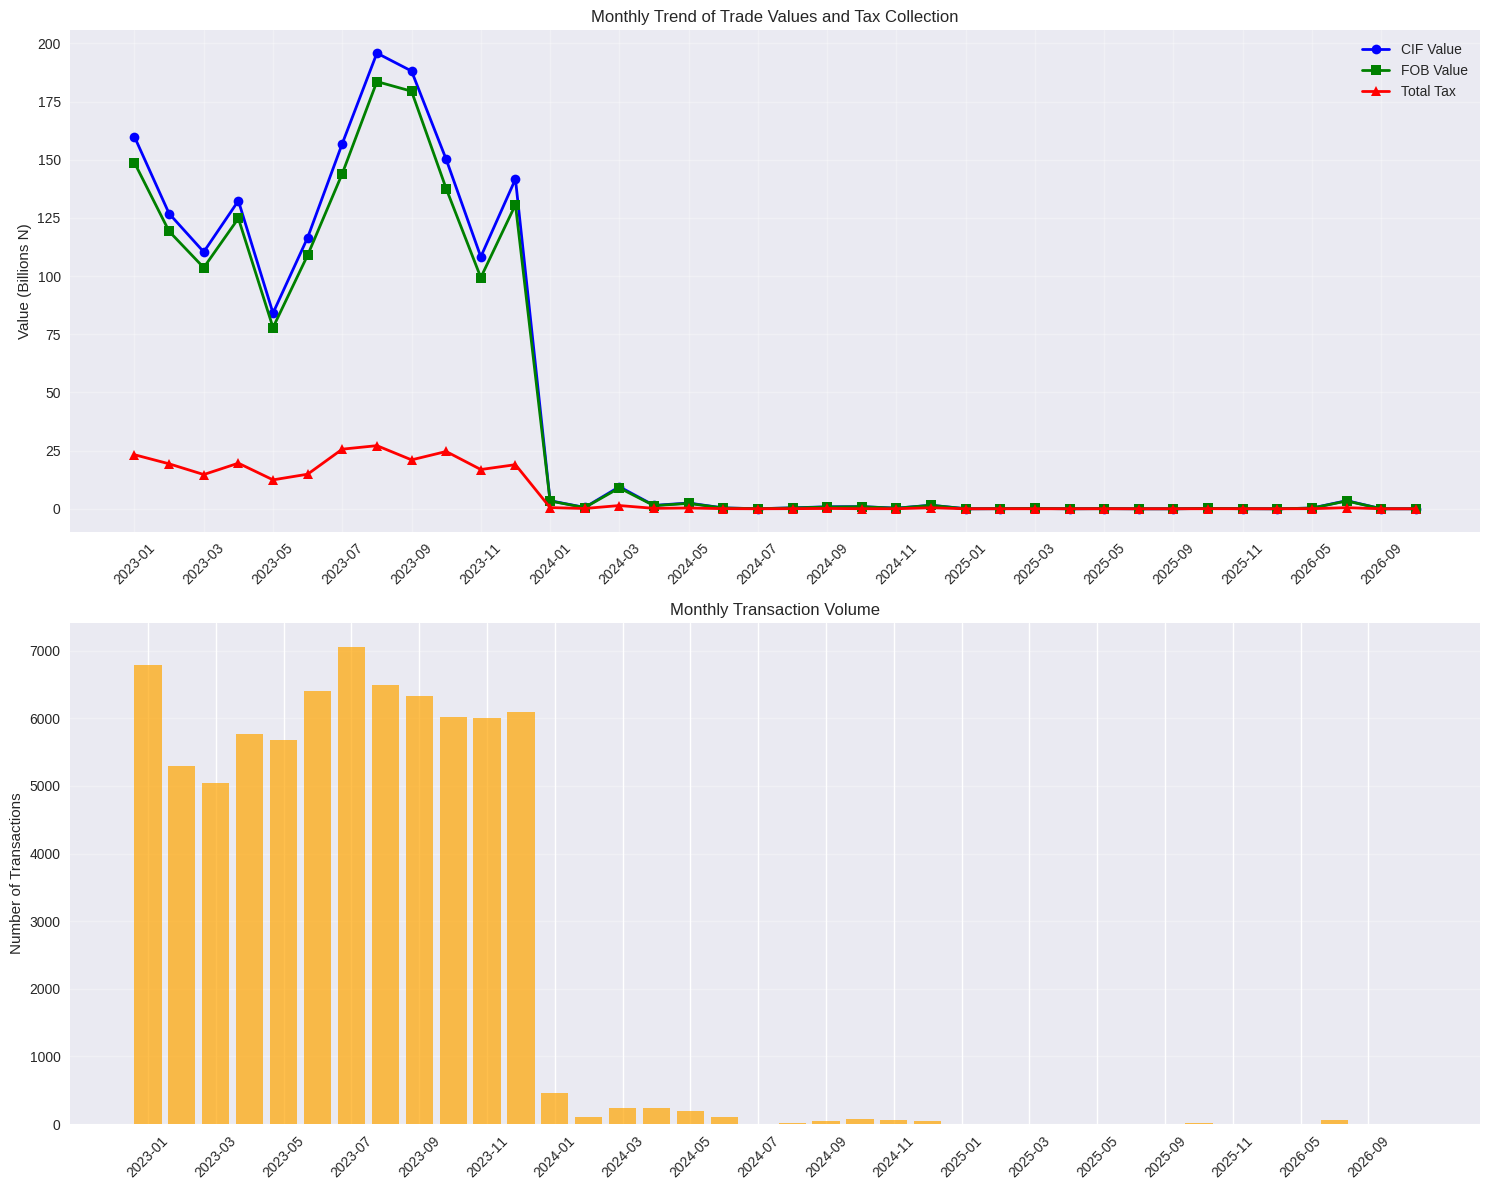

✅ Seasonal analysis created and saved!


In [ ]:
def create_seasonal_analysis():
    """Create seasonal and temporal analysis"""
    global df_enhanced

    if df_enhanced is None:
        print("❌ Error: Please load data first!")
        return

    print("📅 Creating seasonal analysis...")

    # Seasonal Analysis
    monthly_data = df_enhanced.groupby([df_enhanced['Receipt_Date'].dt.to_period('M')]).agg({
        'CIF_Value_N': 'sum',
        'FOB_Value_N': 'sum',
        'Total_Tax_N': 'sum',
        'ID': 'count'
    }).reset_index()

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

    # Monthly values
    x = range(len(monthly_data))
    ax1.plot(x, monthly_data['CIF_Value_N'] / 1e9, marker='o', linewidth=2,
            label='CIF Value', color='blue')
    ax1.plot(x, monthly_data['FOB_Value_N'] / 1e9, marker='s', linewidth=2,
            label='FOB Value', color='green')
    ax1.plot(x, monthly_data['Total_Tax_N'] / 1e9, marker='^', linewidth=2,
            label='Total Tax', color='red')
    ax1.set_xticks(x[::2])  # Show every other month
    ax1.set_xticklabels(monthly_data['Receipt_Date'].astype(str)[::2], rotation=45)
    ax1.set_ylabel('Value (Billions N)')
    ax1.set_title('Monthly Trend of Trade Values and Tax Collection')
    ax1.legend()
    ax1.grid(alpha=0.3)

    # Monthly transaction count
    ax2.bar(x, monthly_data['ID'], alpha=0.7, color='orange')
    ax2.set_xticks(x[::2])
    ax2.set_xticklabels(monthly_data['Receipt_Date'].astype(str)[::2], rotation=45)
    ax2.set_ylabel('Number of Transactions')
    ax2.set_title('Monthly Transaction Volume')
    ax2.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.savefig('seasonal_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("✅ Seasonal analysis created and saved!")

create_seasonal_analysis()

In [ ]:
def build_tax_prediction_models():
    """Build and compare multiple models for tax prediction"""
    global df_enhanced, model_results, best_model, best_model_name, scaler, feature_columns

    if df_enhanced is None:
        print("❌ Error: Please load and prepare data first!")
        return None

    print("🤖 Building tax prediction models...")

    # Prepare features for modeling
    feature_columns = [
        'FOB_Value_N', 'CIF_Value_N', 'Mass_KG', 'FOB_CIF_Diff',
        'Tax_to_Value_Ratio', 'CIF_FOB_Ratio', 'Value_per_KG',
        'Country_Encoded', 'Office_Encoded', 'HS_Category_Encoded',
        'Receipt_Year', 'Receipt_Month', 'Receipt_Quarter', 'Has_Containers',
        'High_Value_Threshold'
    ]

    # Prepare data
    model_df = df_enhanced[feature_columns + ['Total_Tax_N']].copy()
    model_df = model_df.replace([np.inf, -np.inf], np.nan).dropna()

    X = model_df[feature_columns]
    y = model_df['Total_Tax_N']

    print(f"📊 Model training dataset: {X.shape[0]:,} samples, {X.shape[1]} features")

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale features for better performance
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Models to compare
    models = {
        'Linear Regression': LinearRegression(),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
        'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
    }

    model_results = {}

    # Train and evaluate models
    for name, model in models.items():
        print(f"\n🔄 Training {name}...")

        if name == 'Linear Regression':
            # Use scaled features for linear regression
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)
        else:
            # Use original features for tree-based models
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        # Store results
        model_results[name] = {
            'model': model,
            'mse': mse,
            'rmse': rmse,
            'mae': mae,
            'r2': r2,
            'predictions': y_pred,
            'actual': y_test
        }

        print(f"✅ {name} Results:")
        print(f"   RMSE: {rmse:,.2f}")
        print(f"   MAE: {mae:,.2f}")
        print(f"   R²: {r2:.4f}")

    # Select best model
    best_model_name = max(model_results.keys(),
                        key=lambda x: model_results[x]['r2'])
    best_model = model_results[best_model_name]['model']

    print(f"\n🏆 BEST MODEL: {best_model_name}")
    print(f"   R² Score: {model_results[best_model_name]['r2']:.4f}")
    print(f"   RMSE: {model_results[best_model_name]['rmse']:,.2f}")

    return model_results

models = build_tax_prediction_models()

🤖 Building tax prediction models...
📊 Model training dataset: 74,642 samples, 15 features

🔄 Training Linear Regression...
✅ Linear Regression Results:
   RMSE: 6,083,504.65
   MAE: 2,327,687.86
   R²: 0.7376

🔄 Training Random Forest...
✅ Random Forest Results:
   RMSE: 641,577.83
   MAE: 27,229.67
   R²: 0.9971

🔄 Training Gradient Boosting...
✅ Gradient Boosting Results:
   RMSE: 908,384.50
   MAE: 258,690.33
   R²: 0.9942

🏆 BEST MODEL: Random Forest
   R² Score: 0.9971
   RMSE: 641,577.83


📊 Creating model evaluation dashboard...


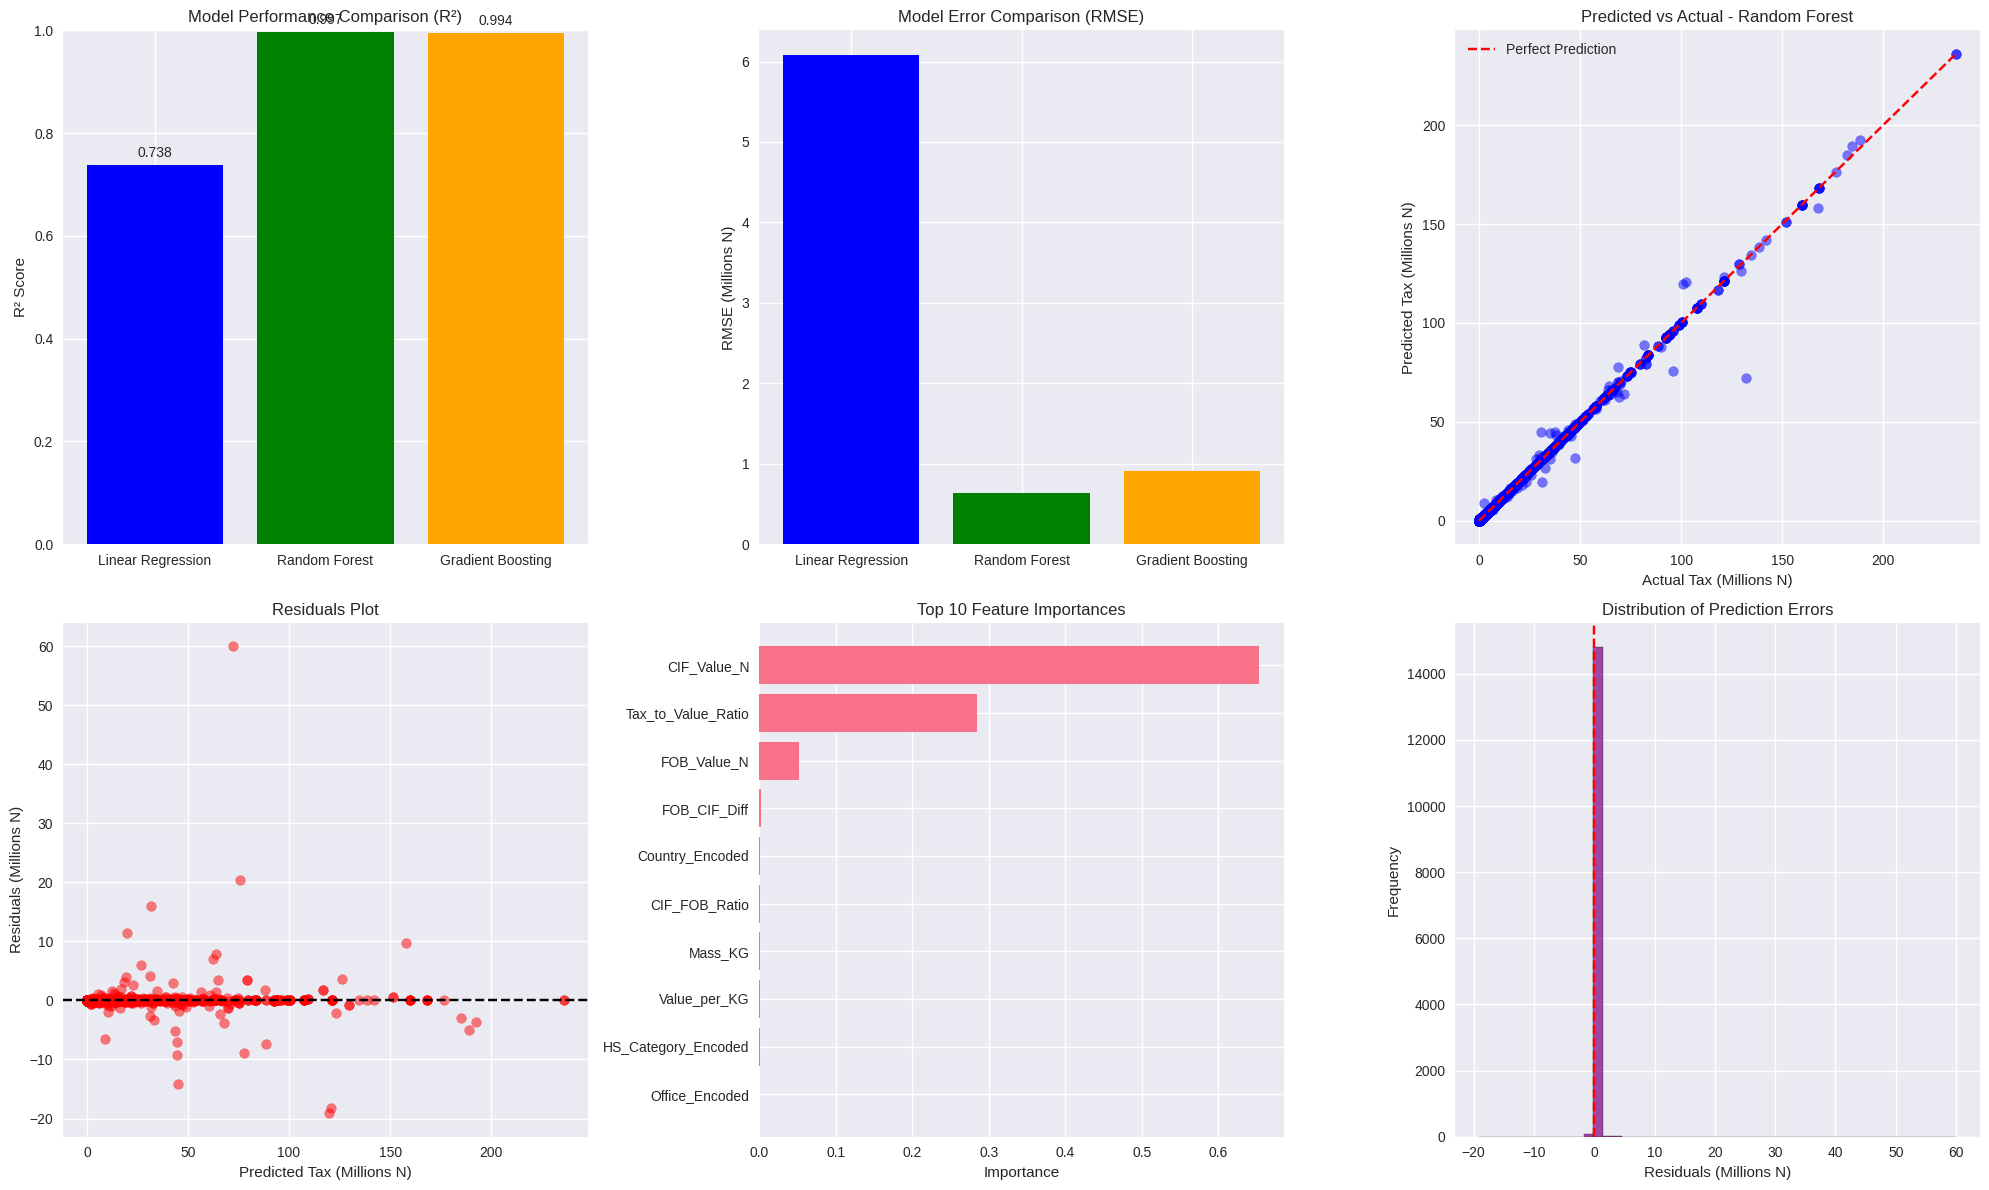

✅ Model evaluation dashboard created and saved!


In [ ]:
def create_model_evaluation_dashboard():
    """Create comprehensive model evaluation visualizations"""
    global model_results, best_model_name, feature_columns, best_model

    if not model_results:
        print("❌ Error: Please build models first!")
        return

    print("📊 Creating model evaluation dashboard...")

    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    axes = axes.ravel()

    # Model comparison
    model_names = list(model_results.keys())
    r2_scores = [model_results[name]['r2'] for name in model_names]
    rmse_scores = [model_results[name]['rmse'] for name in model_names]

    # R² comparison
    bars1 = axes[0].bar(model_names, r2_scores, color=['blue', 'green', 'orange'])
    axes[0].set_title('Model Performance Comparison (R²)')
    axes[0].set_ylabel('R² Score')
    axes[0].set_ylim(0, 1)
    for bar, score in zip(bars1, r2_scores):
        axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{score:.3f}', ha='center', va='bottom')

    # RMSE comparison
    axes[1].bar(model_names, [rmse/1e6 for rmse in rmse_scores], color=['blue', 'green', 'orange'])
    axes[1].set_title('Model Error Comparison (RMSE)')
    axes[1].set_ylabel('RMSE (Millions N)')

    # Predicted vs Actual for best model
    best_result = model_results[best_model_name]
    axes[2].scatter(best_result['actual']/1e6, best_result['predictions']/1e6,
                   alpha=0.5, color='blue')
    axes[2].plot([0, max(best_result['actual'])/1e6], [0, max(best_result['actual'])/1e6],
                'r--', label='Perfect Prediction')
    axes[2].set_xlabel('Actual Tax (Millions N)')
    axes[2].set_ylabel('Predicted Tax (Millions N)')
    axes[2].set_title(f'Predicted vs Actual - {best_model_name}')
    axes[2].legend()

    # Residuals plot
    residuals = best_result['actual'] - best_result['predictions']
    axes[3].scatter(best_result['predictions']/1e6, residuals/1e6, alpha=0.5, color='red')
    axes[3].axhline(y=0, color='black', linestyle='--')
    axes[3].set_xlabel('Predicted Tax (Millions N)')
    axes[3].set_ylabel('Residuals (Millions N)')
    axes[3].set_title('Residuals Plot')

    # Feature importance (for tree-based models)
    if best_model_name in ['Random Forest', 'Gradient Boosting']:
        importance = best_model.feature_importances_
        feature_importance = pd.DataFrame({
            'feature': feature_columns,
            'importance': importance
        }).sort_values('importance', ascending=True).tail(10)

        axes[4].barh(range(len(feature_importance)), feature_importance['importance'])
        axes[4].set_yticks(range(len(feature_importance)))
        axes[4].set_yticklabels(feature_importance['feature'])
        axes[4].set_xlabel('Importance')
        axes[4].set_title('Top 10 Feature Importances')
    else:
        # For linear regression, show coefficients
        coef_df = pd.DataFrame({
            'feature': feature_columns,
            'coefficient': abs(best_model.coef_)
        }).sort_values('coefficient', ascending=True).tail(10)

        axes[4].barh(range(len(coef_df)), coef_df['coefficient'])
        axes[4].set_yticks(range(len(coef_df)))
        axes[4].set_yticklabels(coef_df['feature'])
        axes[4].set_xlabel('Absolute Coefficient')
        axes[4].set_title('Top 10 Feature Coefficients (Absolute)')

    # Error distribution
    axes[5].hist(residuals/1e6, bins=50, alpha=0.7, color='purple', edgecolor='black')
    axes[5].set_xlabel('Residuals (Millions N)')
    axes[5].set_ylabel('Frequency')
    axes[5].set_title('Distribution of Prediction Errors')
    axes[5].axvline(x=0, color='red', linestyle='--')

    plt.tight_layout()
    plt.savefig('model_evaluation_dashboard.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("✅ Model evaluation dashboard created and saved!")

create_model_evaluation_dashboard()

In [ ]:
def predict_tax_for_transaction(transaction_data):
    """Predict tax for a new transaction with detailed explanation"""
    global best_model, best_model_name, model_results, scaler, feature_columns, encoders

    if best_model is None or not model_results:
        print("❌ Error: Please build models first!")
        return None

    print("🎯 Predicting tax for new transaction...")

    # Ensure transaction_data has all required features
    required_features = feature_columns

    # Create DataFrame from transaction data
    if isinstance(transaction_data, dict):
        # Convert single transaction to DataFrame
        trans_df = pd.DataFrame([transaction_data])
    else:
        trans_df = transaction_data.copy()

    # Add missing encoded features if needed
    for col in required_features:
        if col not in trans_df.columns:
            if 'Encoded' in col:
                # Handle encoded columns
                base_col = col.replace('_Encoded', '')
                if base_col == 'Country':
                    base_col = 'Country_of_Origin'
                elif base_col == 'Office':
                    base_col = 'Custom_Office'
                elif base_col == 'HS_Category':
                    base_col = 'HS_Code_Category'

                if base_col in trans_df.columns:
                    encoder_key = col.split('_')[0].lower()
                    if encoder_key in encoders:
                        try:
                            trans_df[col] = encoders[encoder_key].transform(trans_df[base_col])
                        except ValueError:
                            # Handle unseen categories
                            trans_df[col] = 0
                    else:
                        trans_df[col] = 0
                else:
                    trans_df[col] = 0
            else:
                trans_df[col] = 0

    # Select only required features
    X_new = trans_df[required_features]

    # Scale features if using linear regression
    if best_model_name == 'Linear Regression':
        X_new_scaled = scaler.transform(X_new)
        prediction = best_model.predict(X_new_scaled)
    else:
        prediction = best_model.predict(X_new)

    # Create detailed explanation
    print(f"🔍 Tax Prediction Results using {best_model_name}:")
    print(f"   Predicted Tax: {prediction[0]:,.2f} N")
    print(f"   Model Confidence (R²): {model_results[best_model_name]['r2']:.3f}")

    # Show key factors if it's a tree-based model
    if best_model_name in ['Random Forest', 'Gradient Boosting']:
        importance = best_model.feature_importances_
        feature_contrib = pd.DataFrame({
            'feature': feature_columns,
            'importance': importance,
            'value': X_new.iloc[0].values
        }).sort_values('importance', ascending=False).head(5)

        print("\n📈 Top 5 Contributing Factors:")
        for _, row in feature_contrib.iterrows():
            print(f"   {row['feature']}: {row['value']:,.2f} (importance: {row['importance']:.3f})")

    return prediction[0]

In [ ]:
# Example transaction data (replace with your real data)
transaction = {
            'FOB_Value_N': 1046575,
            'CIF_Value_N': 1119220,
            'Mass_KG': 126,
            # Calculated fields - will be re-calculated in predict_tax_for_transaction
            'FOB_CIF_Diff': 72645,
            'Tax_to_Value_Ratio': 0.12,
            'CIF_FOB_Ratio': 1.07,
            'Value_per_KG': 8812.76,
            # Categorical fields
            'Country_of_Origin': "Germany",
            'Custom_Office': "UA PORT",
            'HS_Code_Category': 12,
            # Temporal fields (using default date)
            'Receipt_Date': pd.to_datetime('2023-07-15'),
            'Receipt_Year': 2023,
            'Receipt_Month': 7,
            'Receipt_Quarter': 3,
            'Days_Since_Start': 0, # Default, requires training data min date for accuracy
            # Logistics/Risk fields (using simple heuristics)
            'Nbr_Of_Containers': 0, # Estimate containers
            'Has_Containers': 0,
            'Is_High_Value': 0, # Estimate high value
            'High_Value_Threshold': 0,
             # Assuming not suspicious by default for quick entry
            'Is_Suspicious_Tax': 0,
            'Tax_Anomaly': 0
        }
# Predict tax
predicted_tax = predict_tax_for_transaction(transaction)
print(f"\n💰 Predicted Tax: {predicted_tax:,.2f} N")

🎯 Predicting tax for new transaction...
🔍 Tax Prediction Results using Random Forest:
   Predicted Tax: 136,328.10 N
   Model Confidence (R²): 0.997

📈 Top 5 Contributing Factors:
   CIF_Value_N: 1,119,220.00 (importance: 0.653)
   Tax_to_Value_Ratio: 0.12 (importance: 0.285)
   FOB_Value_N: 1,046,575.00 (importance: 0.052)
   FOB_CIF_Diff: 72,645.00 (importance: 0.003)
   Country_Encoded: 45.00 (importance: 0.001)

💰 Predicted Tax: 136,328.10 N


In [ ]:
def run_policy_simulation(scenarios):
    """Simulate different policy scenarios"""
    global df_enhanced, best_model, best_model_name, scaler, feature_columns

    if best_model is None or df_enhanced is None:
        print("❌ Error: Please build models first!")
        return None

    print("🎭 Running policy simulations...")

    results = {}
    base_tax = df_enhanced['Total_Tax_N'].sum()

    for scenario_name, changes in scenarios.items():
        print(f"\n📊 Scenario: {scenario_name}")

        # Create modified dataset
        sim_df = df_enhanced.copy()

        # Apply changes
        for column, multiplier in changes.items():
            if column in sim_df.columns:
                sim_df[column] = sim_df[column] * multiplier
                print(f"   Modified {column} by factor of {multiplier}")

        # Recalculate derived features
        sim_df['CIF_FOB_Ratio'] = sim_df['CIF_Value_N'] / (sim_df['FOB_Value_N'] + 1)
        sim_df['Tax_to_Value_Ratio'] = sim_df['Total_Tax_N'] / (sim_df['CIF_Value_N'] + 1)
        sim_df['Value_per_KG'] = sim_df['CIF_Value_N'] / (sim_df['Mass_KG'] + 1)

        # Prepare features for prediction
        X_sim = sim_df[feature_columns]

        # Make predictions
        if best_model_name == 'Linear Regression':
            X_sim_scaled = scaler.transform(X_sim)
            predicted_taxes = best_model.predict(X_sim_scaled)
        else:
            predicted_taxes = best_model.predict(X_sim)

        predicted_total = predicted_taxes.sum()
        change = predicted_total - base_tax
        change_pct = (change / base_tax) * 100

        results[scenario_name] = {
            'predicted_total': predicted_total,
            'change': change,
            'change_pct': change_pct
        }

        print(f"   Predicted Total Tax: {predicted_total:,.2f} N")
        print(f"   Change from Base: {change:,.2f} N ({change_pct:.2f}%)")

    print("\n📈 Policy Simulation Summary:")
    print("-" * 40)
    for scenario, result in results.items():
        print(f"{scenario}: {result['change']/1e9:+.1f}B N ({result['change_pct']:+.2f}%)")

    return results

In [ ]:
policy_scenarios = {
        'Increase_CIF_10pct': {'CIF_Value_N': 1.1},
        'Increase_Tax_Rate_5pct': {'Total_Tax_N': 1.05},
        'Combined_Policy': {'CIF_Value_N': 1.08, 'Total_Tax_N': 1.03}
    }

results = run_policy_simulation(policy_scenarios)

🎭 Running policy simulations...

📊 Scenario: Increase_CIF_10pct
   Modified CIF_Value_N by factor of 1.1
   Predicted Total Tax: 240,039,795,982.82 N
   Change from Base: -2,065,880,088.18 N (-0.85%)

📊 Scenario: Increase_Tax_Rate_5pct
   Modified Total_Tax_N by factor of 1.05
   Predicted Total Tax: 257,427,449,310.83 N
   Change from Base: 15,321,773,239.83 N (6.33%)

📊 Scenario: Combined_Policy
   Modified CIF_Value_N by factor of 1.08
   Modified Total_Tax_N by factor of 1.03
   Predicted Total Tax: 239,373,545,037.60 N
   Change from Base: -2,732,131,033.40 N (-1.13%)

📈 Policy Simulation Summary:
----------------------------------------
Increase_CIF_10pct: -2.1B N (-0.85%)
Increase_Tax_Rate_5pct: +15.3B N (+6.33%)
Combined_Policy: -2.7B N (-1.13%)


In [ ]:
def generate_insights_report():
    """Generate comprehensive insights and recommendations"""
    global kpis, df_enhanced

    if not kpis or df_enhanced is None:
        print("❌ Error: Please calculate KPIs first!")
        return None

    print("📋 Generating insights and recommendations...")

    insights = {
        'revenue_insights': [],
        'efficiency_insights': [],
        'compliance_insights': [],
        'recommendations': []
    }

    # Revenue Insights
    top_country = kpis['import_volume_value']['top_7_countries_by_value'].index[0]
    top_country_value = kpis['import_volume_value']['top_7_countries_by_value'].iloc[0]
    total_value = kpis['import_volume_value']['total_cif']
    top_country_pct = (top_country_value / total_value) * 100

    insights['revenue_insights'].append(
        f"{top_country} dominates imports with {top_country_pct:.1f}% of total CIF value "
        f"({top_country_value/1e9:.1f}B N)"
    )

    # Tax efficiency
    avg_tax_ratio = kpis['taxation_revenue']['avg_tax_to_value_ratio']
    insights['efficiency_insights'].append(
        f"Average tax-to-value ratio is {avg_tax_ratio:.2f}, indicating "
        f"{'efficient' if avg_tax_ratio > 0.15 else 'potential for improvement in'} tax collection"
    )

    # Compliance insights
    suspicious_pct = kpis['compliance_processing']['pct_suspicious_tax']
    insights['compliance_insights'].append(
        f"{suspicious_pct:.2f}% of transactions show suspicious tax patterns requiring attention"
    )

    # Recommendations
    insights['recommendations'].extend([
        f"Focus customs resources on {top_country} imports for maximum revenue impact",
        "Implement automated flagging for transactions with tax-to-value ratios below 10th percentile",
        "Consider risk-based inspection protocols for high-value shipments",
        "Develop specialized processing lanes for top importers to improve efficiency",
        "Enhance monitoring of HS code categories with highest values",
        f"Review tax assessment procedures for the {suspicious_pct:.1f}% of suspicious transactions"
    ])

    # Display insights
    print("\n🔍 KEY INSIGHTS:")
    print("=" * 50)
    for category, insight_list in insights.items():
        if insight_list:
            print(f"\n{category.replace('_', ' ').title()}:")
            for insight in insight_list:
                print(f"  • {insight}")

    return insights

generate_insights_report()

📋 Generating insights and recommendations...

🔍 KEY INSIGHTS:

Revenue Insights:
  • China dominates imports with 41.3% of total CIF value (701.6B N)

Efficiency Insights:
  • Average tax-to-value ratio is 0.19, indicating efficient tax collection

Compliance Insights:
  • 1.05% of transactions show suspicious tax patterns requiring attention

Recommendations:
  • Focus customs resources on China imports for maximum revenue impact
  • Implement automated flagging for transactions with tax-to-value ratios below 10th percentile
  • Consider risk-based inspection protocols for high-value shipments
  • Develop specialized processing lanes for top importers to improve efficiency
  • Enhance monitoring of HS code categories with highest values
  • Review tax assessment procedures for the 1.1% of suspicious transactions


{'revenue_insights': ['China dominates imports with 41.3% of total CIF value (701.6B N)'],
 'efficiency_insights': ['Average tax-to-value ratio is 0.19, indicating efficient tax collection'],
 'compliance_insights': ['1.05% of transactions show suspicious tax patterns requiring attention'],
 'recommendations': ['Focus customs resources on China imports for maximum revenue impact',
  'Implement automated flagging for transactions with tax-to-value ratios below 10th percentile',
  'Consider risk-based inspection protocols for high-value shipments',
  'Develop specialized processing lanes for top importers to improve efficiency',
  'Enhance monitoring of HS code categories with highest values',
  'Review tax assessment procedures for the 1.1% of suspicious transactions']}

In [ ]:
def save_analysis_results():
    """Save all analysis results to files"""
    global model_results, kpis, best_model_name

    if not model_results or not kpis:
        print("❌ Error: Please complete analysis first!")
        return

    print("💾 Saving analysis results...")

    # Save model performance
    model_performance = pd.DataFrame({
        'Model': list(model_results.keys()),
        'R2_Score': [result['r2'] for result in model_results.values()],
        'RMSE': [result['rmse'] for result in model_results.values()],
        'MAE': [result['mae'] for result in model_results.values()]
    })
    model_performance.to_csv('model_performance_comparison.csv', index=False)

    # Save KPIs summary
    kpi_summary = {
        'Total_CIF_Value_Trillions': kpis['import_volume_value']['total_cif']/1e12,
        'Total_Tax_Collected_Billions': kpis['taxation_revenue']['total_tax_collected']/1e9,
        'Total_Transactions': kpis['logistics_shipment']['total_shipments'],
        'Average_Tax_Ratio': kpis['taxation_revenue']['avg_tax_to_value_ratio'],
        'Suspicious_Tax_Percentage': kpis['compliance_processing']['pct_suspicious_tax'],
        'Best_Model': best_model_name,
        'Best_Model_R2': model_results[best_model_name]['r2'] if best_model_name else 0
    }

    pd.DataFrame([kpi_summary]).to_csv('executive_kpi_summary.csv', index=False)

    print("✅ Results saved to:")
    print("  • model_performance_comparison.csv")
    print("  • executive_kpi_summary.csv")
    print("  • Various visualization PNG files")

save_analysis_results()

💾 Saving analysis results...
✅ Results saved to:
  • model_performance_comparison.csv
  • executive_kpi_summary.csv
  • Various visualization PNG files


In [ ]:
def demo_tax_prediction():
    """Demonstrate tax prediction with sample transaction"""
    print("🎯 DEMONSTRATION: Tax Prediction")
    print("=" * 50)

    # Example transaction for prediction
    sample_transaction = {
        'FOB_Value_N': 25000000,        # 25M Naira FOB
        'CIF_Value_N': 27500000,        # 27.5M Naira CIF
        'Mass_KG': 15000,               # 15 tons
        'FOB_CIF_Diff': 2500000,        # 2.5M difference
        'Tax_to_Value_Ratio': 0.18,     # 18% tax ratio
        'CIF_FOB_Ratio': 1.069411,           # 10% markup
        'Value_per_KG': 1833.33,        # Value density
        'Country_of_Origin': 'China',   # Most common origin
        'Custom_Office': 'HM CARGO',    # Busy office
        'HS_Code_Category': '28',       # Chemicals
        'Receipt_Year': 2023,
        'Receipt_Month': 7,
        'Receipt_Quarter': 3,
        'Has_Containers': 1,
        'High_Value_Threshold': 1
    }

    predicted_tax = predict_tax_for_transaction(sample_transaction)

    if predicted_tax is not None:
        print(f"\n💰 Sample Transaction Prediction Complete!")
        print(f"   Input CIF Value: {sample_transaction['CIF_Value_N']:,.2f} N")
        print(f"   Predicted Tax: {predicted_tax:,.2f} N")
        print(f"   Predicted Tax Rate: {(predicted_tax/sample_transaction['CIF_Value_N'])*100:.2f}%")

demo_tax_prediction()

🎯 DEMONSTRATION: Tax Prediction
🎯 Predicting tax for new transaction...
🔍 Tax Prediction Results using Random Forest:
   Predicted Tax: 5,708,175.17 N
   Model Confidence (R²): 0.997

📈 Top 5 Contributing Factors:
   CIF_Value_N: 27,500,000.00 (importance: 0.653)
   Tax_to_Value_Ratio: 0.18 (importance: 0.285)
   FOB_Value_N: 25,000,000.00 (importance: 0.052)
   FOB_CIF_Diff: 2,500,000.00 (importance: 0.003)
   Country_Encoded: 24.00 (importance: 0.001)

💰 Sample Transaction Prediction Complete!
   Input CIF Value: 27,500,000.00 N
   Predicted Tax: 5,708,175.17 N
   Predicted Tax Rate: 20.76%


In [ ]:
def demo_policy_scenarios():
    """Demonstrate policy simulation with sample scenarios"""
    print("🎭 DEMONSTRATION: Policy Scenarios")
    print("=" * 50)

    policy_scenarios = {
        'Increase_CIF_10pct': {'CIF_Value_N': 1.1},
        'Increase_Tax_Rate_5pct': {'Total_Tax_N': 1.05},
        'Combined_Policy': {'CIF_Value_N': 1.08, 'Total_Tax_N': 1.03},
        'Economic_Downturn': {'CIF_Value_N': 0.85, 'FOB_Value_N': 0.85}
    }

    results = run_policy_simulation(policy_scenarios)
    return results

policy_results = demo_policy_scenarios()

🎭 DEMONSTRATION: Policy Scenarios
🎭 Running policy simulations...

📊 Scenario: Increase_CIF_10pct
   Modified CIF_Value_N by factor of 1.1
   Predicted Total Tax: 240,039,795,982.82 N
   Change from Base: -2,065,880,088.18 N (-0.85%)

📊 Scenario: Increase_Tax_Rate_5pct
   Modified Total_Tax_N by factor of 1.05
   Predicted Total Tax: 257,427,449,310.83 N
   Change from Base: 15,321,773,239.83 N (6.33%)

📊 Scenario: Combined_Policy
   Modified CIF_Value_N by factor of 1.08
   Modified Total_Tax_N by factor of 1.03
   Predicted Total Tax: 239,373,545,037.60 N
   Change from Base: -2,732,131,033.40 N (-1.13%)

📊 Scenario: Economic_Downturn
   Modified CIF_Value_N by factor of 0.85
   Modified FOB_Value_N by factor of 0.85
   Predicted Total Tax: 228,898,456,229.43 N
   Change from Base: -13,207,219,841.57 N (-5.46%)

📈 Policy Simulation Summary:
----------------------------------------
Increase_CIF_10pct: -2.1B N (-0.85%)
Increase_Tax_Rate_5pct: +15.3B N (+6.33%)
Combined_Policy: -2.7B N 

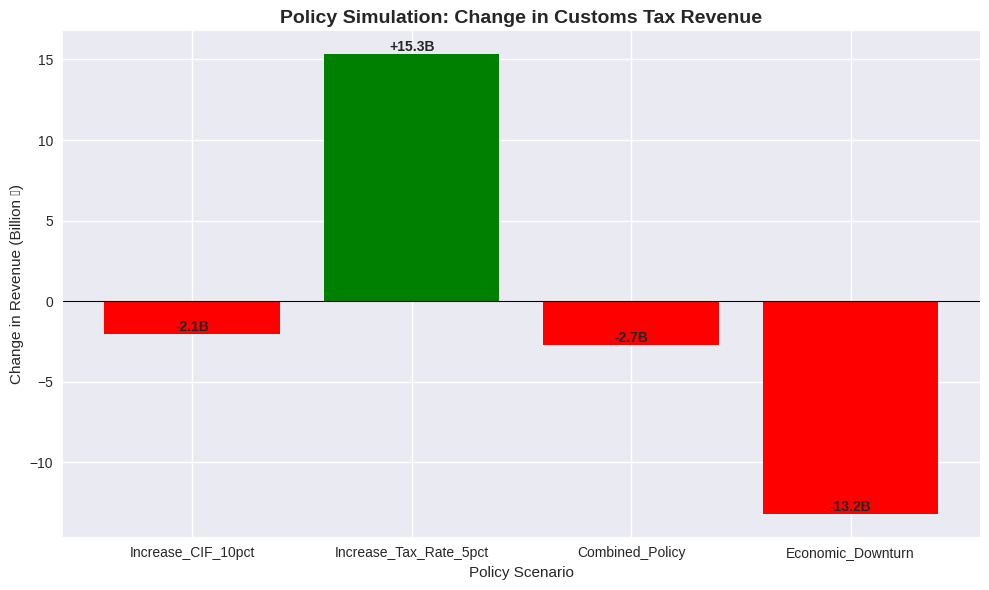

In [ ]:
import matplotlib.pyplot as plt

# Data from your simulation results
scenarios = [
    "Increase_CIF_10pct",
    "Increase_Tax_Rate_5pct",
    "Combined_Policy",
    "Economic_Downturn"
]

change_values = [
    -2_065_880_088.18,  # Increase_CIF_10pct
    15_321_773_239.83,  # Increase_Tax_Rate_5pct
    -2_732_131_033.40,  # Combined_Policy
    -13_207_219_841.57  # Economic_Downturn
]

# Create bar colors based on positive/negative change
colors = ['green' if val > 0 else 'red' for val in change_values]

# Plot
plt.figure(figsize=(10, 6))
bars = plt.bar(scenarios, [val/1e9 for val in change_values], color=colors)  # Convert to billions

# Add labels on bars
for bar, value in zip(bars, change_values):
    plt.text(bar.get_x() + bar.get_width()/2,
             bar.get_height(),
             f"{value/1e9:+.1f}B",
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# Formatting
plt.axhline(0, color='black', linewidth=0.8)
plt.title("Policy Simulation: Change in Customs Tax Revenue", fontsize=14, fontweight='bold')
plt.ylabel("Change in Revenue (Billion ₦)")
plt.xlabel("Policy Scenario")
plt.tight_layout()

plt.show()
